## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML Helpers/Metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

# trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# fun ones
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Reusable Function for ML Experimentation

5-fold cross validation + train/test splits to generate images

Target metrics to minimize are cross validation RMSE + MAE

In [2]:
# Helper Function
def doMLRegression(model, X_train, y_train, X_test, y_test):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validate the model
    cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_mse)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

    # Print cross-validation metrics
    print("CROSS-VALIDATION METRICS (Training Data)")
    print(f"Mean R2: {np.mean(cv_r2)}")
    print(f"Mean MSE: {np.mean(-cv_mse)}")
    print(f"Mean RMSE: {np.mean(cv_rmse)}")
    print(f"Mean MAE: {np.mean(-cv_mae)}")
    print()
    
    # fit the model
    model.fit(X_train, y_train)

    # predict the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # get the TRAIN metrics
    resids = y_train - train_preds
    r2 = r2_score(y_train, train_preds)
    mse = mean_squared_error(y_train, train_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, train_preds)

    # Print releveant metrics.
    print("TRAINING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")
    
    # get the TEST metrics
    resids = y_test - test_preds
    r2 = r2_score(y_test, test_preds)
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_preds)

    # Print releveant metrics.
    print()
    print("TESTING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")

    # Predicted vs Actual Graph
    plt.scatter(test_preds, y_test)
    plt.xlabel("Predictions")
    plt.ylabel("Observed")
    plt.title("Predicted vs Actual Plot")
    plt.plot(y_test, y_test)
    plt.show()

    # Residual Graph
    plt.scatter(test_preds, resids)
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.plot(test_preds, np.zeros(len(test_preds)))
    plt.show()

## Load data

Exclude 2022 as a holdout set to evaluation model performance

In [3]:
df = pd.read_csv("output/data/ml_soccer_data.csv")
df = df.loc[df.season_name != 2022]
print(df.shape)
df.head()

(2927, 58)


,season_name,player_id,player_name,minutes_played,offensive_goals_added,offensive_goals_added_90,player_age,guaranteed_compensation_1,minutes_played_1,share_team_touches_1,attempted_passes_1,completed_passes_1,total_distance_yds_1,total_vertical_distance_yds_1,xcompleted_passes_1,goals_added_above_avg_Dribbling_1,goals_added_above_avg_Fouling_1,goals_added_above_avg_Interrupting_1,goals_added_above_avg_Passing_1,goals_added_above_avg_Receiving_1,goals_added_above_avg_Shooting_1,guaranteed_compensation_2,minutes_played_2,share_team_touches_2,attempted_passes_2,completed_passes_2,total_distance_yds_2,total_vertical_distance_yds_2,xcompleted_passes_2,goals_added_above_avg_Dribbling_2,goals_added_above_avg_Fouling_2,goals_added_above_avg_Interrupting_2,goals_added_above_avg_Passing_2,goals_added_above_avg_Receiving_2,goals_added_above_avg_Shooting_2,guaranteed_compensation_3,minutes_played_3,share_team_touches_3,attempted_passes_3,completed_passes_3,total_distance_yds_3,total_vertical_distance_yds_3,xcompleted_passes_3,goals_added_above_avg_Dribbling_3,goals_added_above_avg_Fouling_3,goals_added_above_avg_Interrupting_3,goals_added_above_avg_Passing_3,goals_added_above_avg_Receiving_3,goals_added_above_avg_Shooting_3,played_two_years_ago,played_three_years_ago,primary_position_AM,primary_position_CB,primary_position_CM,primary_position_DM,primary_position_FB,primary_position_ST,primary_position_W
0,2014,0Oq60APM6D,Jason Hernandez,1868.0,-1.202600,-0.057941,30.0,208333.0,1817.0,0.064367,513.0,412.0,12260.3289,5384.6294,422.5266,0.1371,0.15161,-1.1739,-0.5978,-0.4063,-0.2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
1,2014,0Oq60VgM6D,Jeff Larentowicz,3211.0,0.071294,0.001998,30.0,231000.0,3024.0,0.092425,1217.0,928.0,24863.7753,8774.1994,962.7394,-0.4790,0.26440,-1.1032,0.0300,0.3525,0.1768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,False
2,2014,0Oq67EgQ6D,Matt Besler,2415.0,1.094000,0.040770,26.0,180000.0,2811.0,0.113450,1605.0,1242.0,44430.6794,20073.7718,1242.5560,0.1821,0.25460,-1.8372,1.9678,-0.3481,-0.2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
3,2014,0Oq67k7Q6D,Tristan Bowen,69.0,-0.016700,-0.021783,22.0,156364.0,1259.0,0.053732,380.0,236.0,6457.6914,728.7155,270.9217,-0.4333,-0.16740,0.2524,0.0546,-0.9820,-0.3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,True,False
4,2014,0Oq67xxQ6D,Brandon Barklage,970.0,0.263000,0.024402,27.0,71428.5,2011.0,0.079036,1063.0,795.0,22768.3239,10058.4741,808.8326,-0.4377,-0.05840,0.6478,0.6542,-0.1870,-0.0851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False


# Predict offensive_goals_added

In [4]:
# Create our train/test set
target_cols = ['season_name', 'player_id', 'player_name', 'minutes_played', 'offensive_goals_added', 'offensive_goals_added_90']

X = df.drop(columns=target_cols)
y = df["offensive_goals_added"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.25,
                                                    random_state=42,)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2195, 52) (2195,)
(732, 52) (732,)


### Model Experimentation

Linear models will use a StandardScaler to normalize the input features

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.24305740125698755
Mean MSE: 0.9210968122354121
Mean RMSE: 0.9578377786517835
Mean MAE: 0.6424211960404616

TRAINING SET METRICS
The r2 is 0.30668119324965426.
The mean squared error is 0.8500901339839531.
The root mean squared error is 0.9220033264495053.
The mean absolute error is 0.6216553952485906.

TESTING SET METRICS
The r2 is 0.2413508424607408.
The mean squared error is 0.8635622364128686.
The root mean squared error is 0.9292804939375778.
The mean absolute error is 0.6491708270442361.


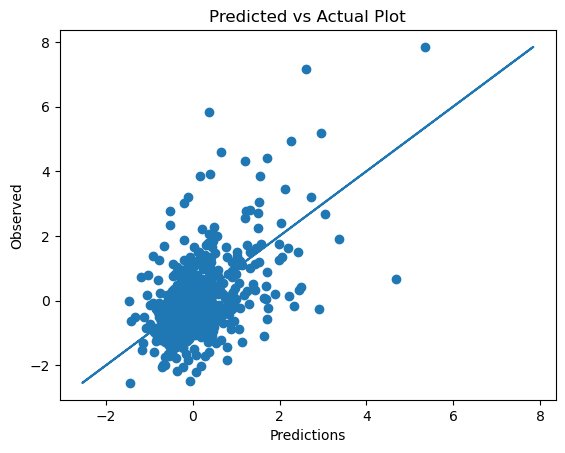

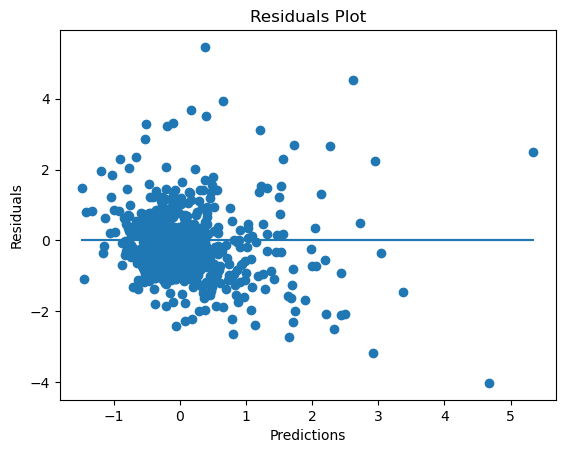

In [5]:
lr = Pipeline([
    ('scaler', StandardScaler()), 
    ('lr', LinearRegression())
])
doMLRegression(lr, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.2462527810047745
Mean MSE: 0.9168738565852774
Mean RMSE: 0.9557029860622845
Mean MAE: 0.6413482904660934

TRAINING SET METRICS
The r2 is 0.306338251113906.
The mean squared error is 0.8505106212450637.
The root mean squared error is 0.9222313274038482.
The mean absolute error is 0.6215662385093977.

TESTING SET METRICS
The r2 is 0.24156056183935282.
The mean squared error is 0.8633235150832347.
The root mean squared error is 0.9291520408863313.
The mean absolute error is 0.6492699225117345.


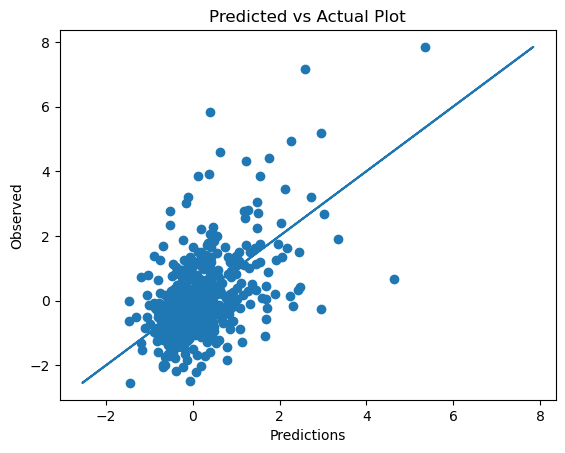

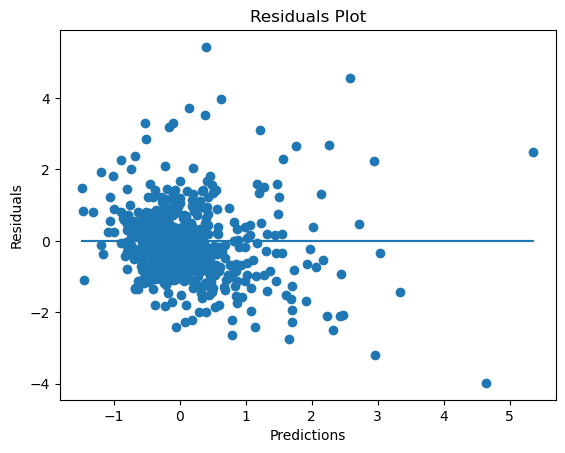

In [6]:
ridge = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
doMLRegression(ridge, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: -0.002002902620932412
Mean MSE: 1.2269834973495233
Mean RMSE: 1.1047099975119075
Mean MAE: 0.7182548757362166

TRAINING SET METRICS
The r2 is 0.0.
The mean squared error is 1.2261172287658113.
The root mean squared error is 1.1073017785435961.
The mean absolute error is 0.7179089369399541.

TESTING SET METRICS
The r2 is -0.00619407571851327.
The mean squared error is 1.1453399738968184.
The root mean squared error is 1.0702055755306166.
The mean absolute error is 0.7089014595962939.


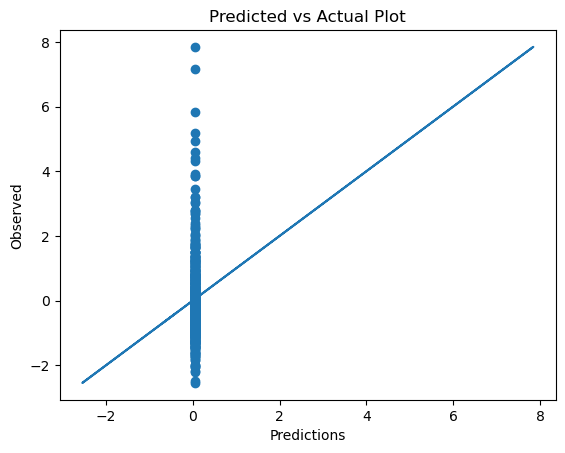

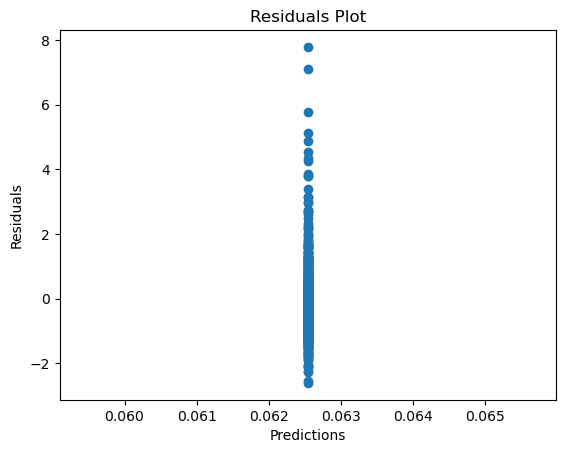

In [7]:
en = Pipeline([
    ('scaler', StandardScaler()), 
    ('en', ElasticNet())
])
doMLRegression(en, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.04356293483237779
Mean MSE: 1.1721141888766495
Mean RMSE: 1.0789718568149058
Mean MAE: 0.7159940724415599

TRAINING SET METRICS
The r2 is 0.1687564975228515.
The mean squared error is 1.019201979686868.
The root mean squared error is 1.0095553376050608.
The mean absolute error is 0.6686731112413683.

TESTING SET METRICS
The r2 is 0.023756258493849658.
The mean squared error is 1.1112478282235365.
The root mean squared error is 1.0541574020152478.
The mean absolute error is 0.7202304439735863.


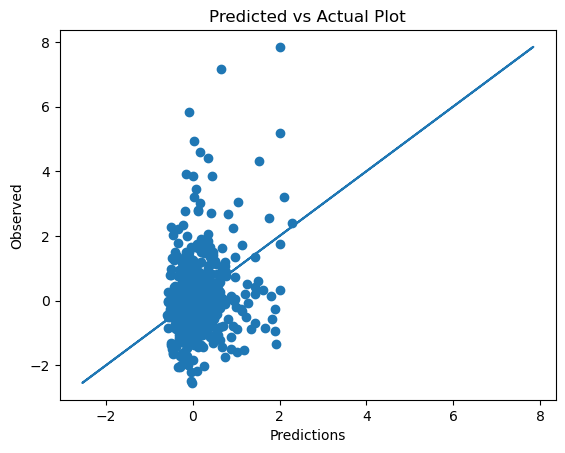

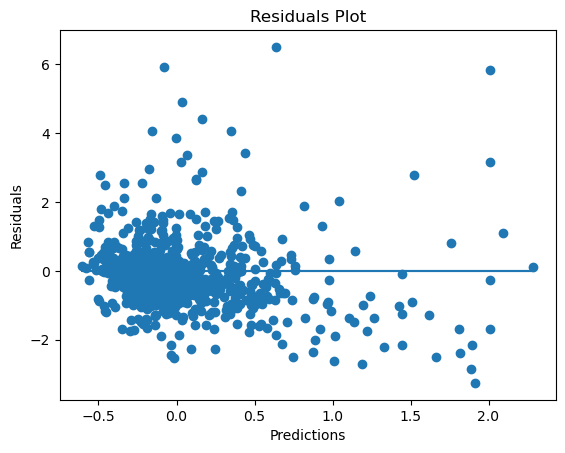

In [8]:
knn = KNeighborsRegressor(n_neighbors=15)
doMLRegression(knn, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.1891835227968351
Mean MSE: 0.9883821623689691
Mean RMSE: 0.9912347023362426
Mean MAE: 0.6534069299077337

TRAINING SET METRICS
The r2 is 0.8903637221799833.
The mean squared error is 0.13442692913287754.
The root mean squared error is 0.36664278137292916.
The mean absolute error is 0.2423019327025577.

TESTING SET METRICS
The r2 is 0.22483539508903827.
The mean squared error is 0.8823615938311603.
The root mean squared error is 0.9393410423435997.
The mean absolute error is 0.6573166221451275.


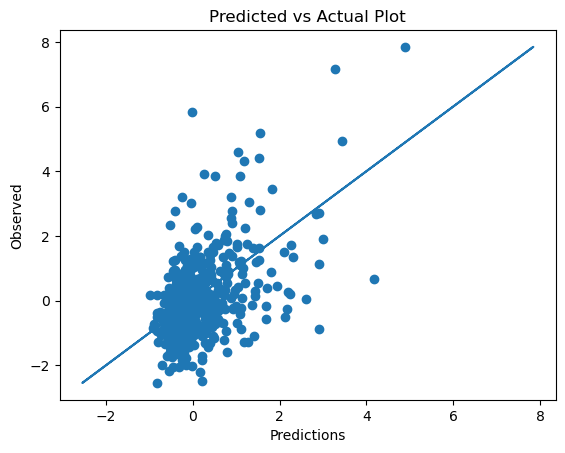

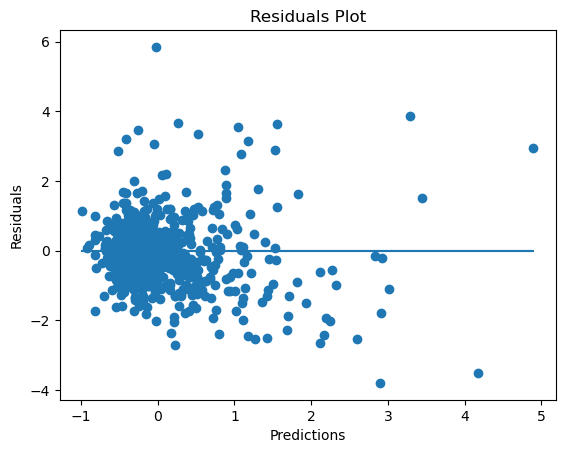

In [9]:
rf = RandomForestRegressor(random_state=42)
doMLRegression(rf, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.013240903101887214
Mean MSE: 1.1924456747757994
Mean RMSE: 1.0908461535975038
Mean MAE: 0.7923120868510809

TRAINING SET METRICS
The r2 is 0.21100515390428332.
The mean squared error is 0.967400174205388.
The root mean squared error is 0.9835650330330924.
The mean absolute error is 0.7866853851094752.

TESTING SET METRICS
The r2 is -0.07730388552790757.
The mean squared error is 1.2262835112086838.
The root mean squared error is 1.1073768605170888.
The mean absolute error is 0.8805152222605908.


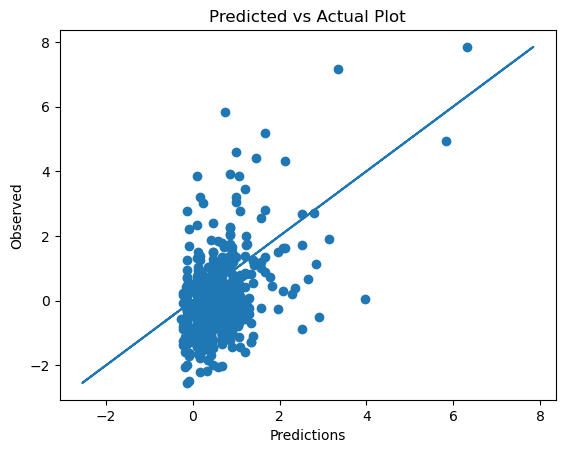

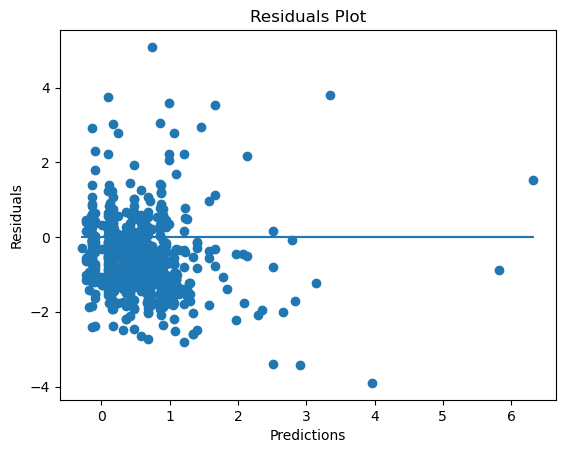

In [10]:
ada = AdaBoostRegressor(random_state=42)
doMLRegression(ada, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.1094487076561101
Mean MSE: 1.0764244426170797
Mean RMSE: 1.0358566008268801
Mean MAE: 0.6906729342480629

TRAINING SET METRICS
The r2 is 0.983300163514957.
The mean squared error is 0.020475957231883207.
The root mean squared error is 0.14309422501234356.
The mean absolute error is 0.09624756408636073.

TESTING SET METRICS
The r2 is 0.12531150094852173.
The mean squared error is 0.9956485799780531.
The root mean squared error is 0.9978219179683583.
The mean absolute error is 0.7084948420304423.


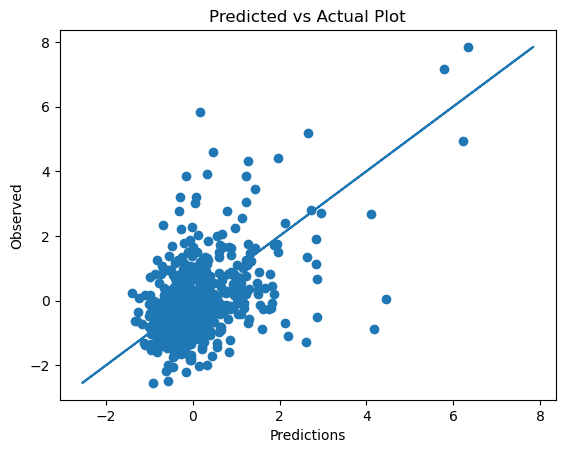

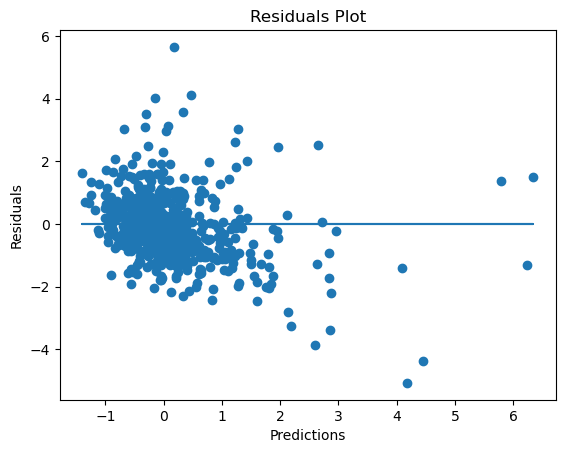

In [11]:
xgb = XGBRegressor(random_state=42)
doMLRegression(xgb, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.12138333774130086
Mean MSE: 1.0715265431117242
Mean RMSE: 1.0322778103111523
Mean MAE: 0.6888893251742684

TRAINING SET METRICS
The r2 is 0.8439349441895739.
The mean squared error is 0.1913540537374613.
The root mean squared error is 0.43744034306115537.
The mean absolute error is 0.2973967142595644.

TESTING SET METRICS
The r2 is 0.1667419904007631.
The mean squared error is 0.9484886961615265.
The root mean squared error is 0.9739038433857454.
The mean absolute error is 0.6957370266324883.


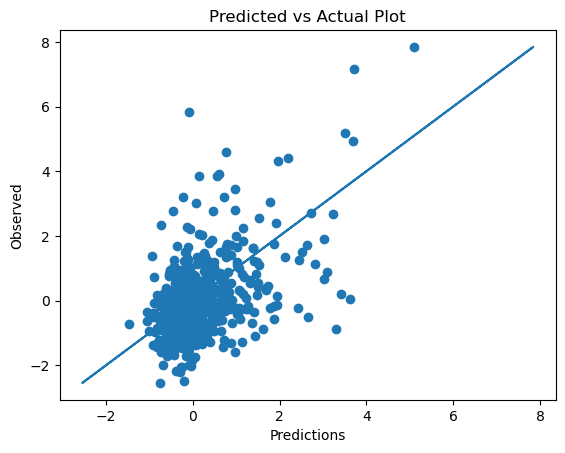

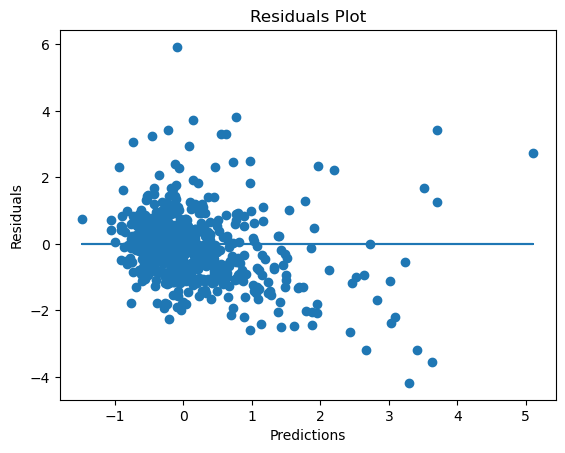

In [12]:
lgb = LGBMRegressor(random_state=42, verbosity=-1)
doMLRegression(lgb, X_train, y_train, X_test, y_test)

In [13]:
fi = pd.DataFrame(list(zip(X.columns, lgb.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
14,goals_added_above_avg_Shooting_1,265
1,guaranteed_compensation_1,235
12,goals_added_above_avg_Passing_1,217
9,goals_added_above_avg_Dribbling_1,216
13,goals_added_above_avg_Receiving_1,182
3,share_team_touches_1,152
10,goals_added_above_avg_Fouling_1,141
7,total_vertical_distance_yds_1,120
23,goals_added_above_avg_Dribbling_2,106
2,minutes_played_1,98


## Results

Ridge model performs the best in MAE/RMSE. 

Tree and boosted models do not perform as well as the linear models.

Feature importances seem to make sense - Passing, and touches in the prior year are most important, similar to OGA_90 model.

## Model Selection

In [14]:
import pickle

# Initialize and train the model on the entire dataset
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
model.fit(X, y)

# Get absolute coefficients
coef_abs = np.abs(model["ridge"].coef_)

# Normalize the coefficients (optional)
coef_normalized = coef_abs / np.sum(coef_abs)
fi = pd.DataFrame(list(zip(X.columns, coef_normalized)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
36,xcompleted_passes_3,0.078004
5,completed_passes_1,0.077271
33,completed_passes_3,0.071074
8,xcompleted_passes_1,0.065876
18,attempted_passes_2,0.050906
15,guaranteed_compensation_2,0.048656
32,attempted_passes_3,0.048549
1,guaranteed_compensation_1,0.047011
34,total_distance_yds_3,0.045283
12,goals_added_above_avg_Passing_1,0.044498


In [15]:
# Save the model to a file
with open('models/eval/oga_model_eval.pkl', 'wb') as file:
    pickle.dump(model, file)